In [20]:
import pandas as pd
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [21]:
column_names = ["TPSA(Tot)", "SAacc", "H-050", "MLOGP", "RDCHI", "GATS1p", "nN", "C-040", "quantitative response"]
df = pd.read_csv('qsar_aquatic_toxicity.csv', names=column_names, delimiter=';')
df.head()

,TPSA(Tot),SAacc,H-050,MLOGP,RDCHI,GATS1p,nN,C-040,quantitative response
0,0.00,0.0,0,2.419,1.225,0.667,0,0,3.740
1,0.00,0.0,0,2.638,1.401,0.632,0,0,4.330
2,9.23,11.0,0,5.799,2.930,0.486,0,0,7.019
3,9.23,11.0,0,5.453,2.887,0.495,0,0,6.723
4,9.23,11.0,0,4.068,2.758,0.695,0,0,5.979


In [22]:
train_df, test_df = train_test_split(df, test_size=0.2)
x_train, y_train = train_df.drop('quantitative response', axis=1), train_df['quantitative response']
x_test, y_test = test_df.drop('quantitative response', axis=1), test_df['quantitative response']

In [23]:
train_df.head()

,TPSA(Tot),SAacc,H-050,MLOGP,RDCHI,GATS1p,nN,C-040,quantitative response
29,3.24,3.124,0,4.480,3.258,1.310,1,0,5.721
545,0.00,0.000,0,2.255,1.800,0.917,0,0,2.480
471,129.95,30.530,0,1.145,2.637,1.444,0,0,9.150
530,116.67,180.366,4,-1.960,2.021,1.830,1,1,3.908
204,45.82,50.747,0,2.241,2.108,0.942,1,0,4.040


In [24]:
DENSE1_SIZE = 128
DENSE2_SIZE = 64
DENSE3_SIZE = 32

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(x_train.shape[1:])),
        tf.keras.layers.Dense(DENSE1_SIZE, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(DENSE2_SIZE, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(DENSE3_SIZE, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               1152      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [25]:
# %pip install pydot graphviz

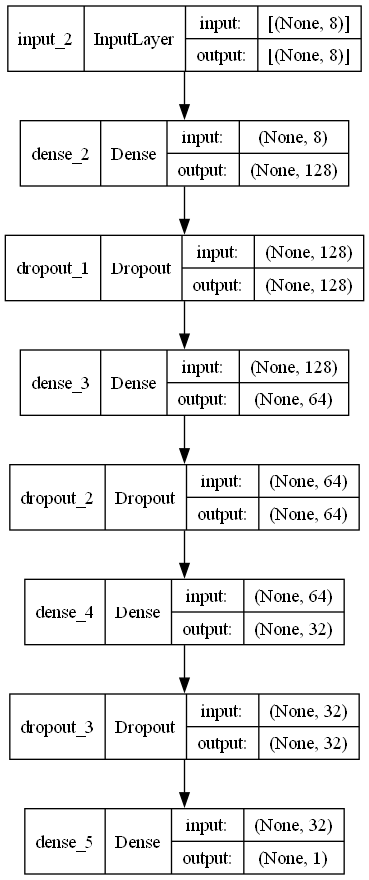

In [26]:
from tensorflow.keras.utils import plot_model


# to make graphviz visible on my python env even though its already there on my cmd path
import os
os.environ['PATH'] += r';D:\opt\Graphviz\bin'
###

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [28]:
model.input.shape

TensorShape([None, 8])

In [29]:
predictions = model(x_test.to_numpy())

In [30]:
loss_fn = tf.keras.losses.MeanSquaredError()

In [31]:
loss_fn(y_test.to_numpy(), predictions).numpy()

193.70764

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=loss_fn,
              metrics=['mse', 'mae'])

In [39]:
NUM_OF_EPOCHS = 100
model.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=NUM_OF_EPOCHS)

Epoch 1/100
14/14 [==============================] - 2s 27ms/step - loss: 1.6143 - mse: 1.6143 - mae: 0.9713 - val_loss: 1.6390 - val_mse: 1.6390 - val_mae: 0.9032
Epoch 2/100
14/14 [==============================] - 0s 7ms/step - loss: 1.6481 - mse: 1.6481 - mae: 0.9870 - val_loss: 1.6619 - val_mse: 1.6619 - val_mae: 0.9131
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: 1.5550 - mse: 1.5550 - mae: 0.9682 - val_loss: 1.6348 - val_mse: 1.6348 - val_mae: 0.9026
Epoch 4/100
14/14 [==============================] - 0s 8ms/step - loss: 1.4732 - mse: 1.4732 - mae: 0.9392 - val_loss: 1.6628 - val_mse: 1.6628 - val_mae: 0.9059
Epoch 5/100
14/14 [==============================] - 0s 7ms/step - loss: 1.4835 - mse: 1.4835 - mae: 0.9393 - val_loss: 1.6061 - val_mse: 1.6061 - val_mae: 0.8881
Epoch 6/100
14/14 [==============================] - 0s 6ms/step - loss: 1.5936 - mse: 1.5936 - mae: 0.9572 - val_loss: 1.5835 - val_mse: 1.5835 - val_mae: 0.8822
Epoch 7/100
14/14 [==

In [40]:
model.evaluate(x_test,  y_test, verbose=2)

4/4 - 0s - loss: 1.6576 - mse: 1.6576 - mae: 0.9040 - 41ms/epoch - 10ms/step


[1.657597303390503, 1.657597303390503, 0.9040090441703796]

In [65]:
loss, mse, mae = model.evaluate(x_test, y_test)
print(f"Test MSE: {mse}, Test MAE: {mae}")

4/4 [==============================] - 0s 3ms/step - loss: 1.6576 - mse: 1.6576 - mae: 0.9040
Test MSE: 1.657597303390503, Test MAE: 0.9040090441703796


In [67]:
loss, mse, mae = model.evaluate(x_train, y_train)
print(f"Train MSE: {mse}, Train MAE: {mae}")

14/14 [==============================] - 0s 3ms/step - loss: 1.3148 - mse: 1.3148 - mae: 0.8474
Train MSE: 1.31478750705719, Train MAE: 0.8474133014678955


In [41]:
y_pred = model.predict(x_test)

In [42]:
x_test.shape, y_pred.flatten().shape, y_test.shape

((110, 8), (110,), (110,))

In [43]:
summary_df = pd.DataFrame({'Input': x_test.to_numpy().tolist(), 'Actual': y_test.to_numpy(), 'Predicted': y_pred.flatten()})
summary_df.head()

,Input,Actual,Predicted
0,"[180.08, 310.81, 5.0, 0.143, 4.805, 1.597, 2.0...",3.795,3.600834
1,"[63.22, 80.144, 0.0, 1.936, 3.852, 1.151, 0.0,...",8.028,4.755800
2,"[26.02, 32.897, 2.0, 2.729, 1.975, 0.462, 1.0,...",5.437,4.799356
3,"[86.71, 27.185, 0.0, 2.06, 2.394, 1.088, 0.0, ...",6.579,6.420289
4,"[0.0, 0.0, 0.0, 3.516, 1.678, 1.667, 0.0, 0.0]",4.340,3.875564


In [44]:
def representative_dataset():
    for _ in range(100):
      data =  x_train
      yield [data.astype(np.float32)]

print(representative_dataset())

<generator object representative_dataset at 0x000002A28116D348>


In [45]:
tf.saved_model.save(model, "saved_QSAR_model_keras_dir")

INFO:tensorflow:Assets written to: saved_QSAR_model_keras_dir\assets


In [46]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("saved_QSAR_model_keras_dir")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
tflite_model = converter.convert()

In [47]:
with open('QSARClassifyModel_new.tflite', 'wb') as f:
  f.write(tflite_model)

In [48]:
interpreter = tf.lite.Interpreter(model_path="QSARClassifyModel_new.tflite")
interpreter.allocate_tensors()

In [49]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print('input_details:\n', input_details)
print('output_details:\n', output_details)

input_details:
 [{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([1, 8]), 'shape_signature': array([-1,  8]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
output_details:
 [{'name': 'StatefulPartitionedCall:0', 'index': 14, 'shape': array([1, 1]), 'shape_signature': array([-1,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [50]:
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [51]:
# Test the model on random input data.
input_shape = input_details[0]['shape']
print(input_shape)
input_data = [x_test_np[0]]
#print(input_data)
input_data = np.array(input_data, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)
print(y_test_np[0])

[1 8]
[[3.9490638]]
3.795


In [53]:
# Function to convert some hex values into an array for C programming
import time, sys

# Function to convert some hex values into an array for C programming
def hex_to_c_array(hex_data, var_name):
    c_str = ""

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += "#define " + var_name.upper() + '_H\n\n'

    c_str += "/*\n Author: Mouli Sankaran \n"
    c_str += " CAUTION: This is an auto generated file.\n DO NOT EDIT OR MAKE ANY CHANGES TO IT.\n"

# Time stamping of this model data in the generated file
    localtime = time.asctime( time.localtime(time.time()) )
    c_str += " This model data was generated on " + localtime+ '\n\n'
    print("This model data was generated on:", localtime)

# Add information about the verisons of tools and packages used in generating this header file
    c_str += " Tools used:\n Python:" + str(sys.version) + "\n Numpy:" \
            + str(np.version.version) + "\n TensorFlow:" + str(sys.version) \
            + "\n Keras: "+ str(tf.keras.__version__) + "\n\n"
    print("Tools used: Python:", sys.version, "\n Numpy:", np.version.version, \
          "\n TensorFlow:", sys.version, "\n Keras: ", tf.keras.__version__, "\n\n")

# Training details of the model
    c_str += ' Model details are:\n'
    c_str += ' NUM_OF_EPOCHS  = ' + str(NUM_OF_EPOCHS) + '\n*/\n'

# Generate 'C' constants for the no. of nodes in each layer
    c_str +=   'const int ' + 'DENSE1_SIZE' + ' = ' + str(DENSE1_SIZE) + ';\n'

    # Add array length at the top of the file
    c_str += '\nalignas(8) const unsigned int ' + var_name + '_len = '\
            + str(len(hex_data)) + ';\n'

    # Declare C variable
    c_str += 'const unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data):
        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formating so each line stays within 80 characters
        if (i + 1) < len(hex_data):
          hex_str += ','
        if (i + 1) % 12 == 0:
          hex_str += '\n'
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n' + format(''.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

In [54]:
with open("QSAR_model_esp32_new" + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, "QSAR_model_esp32_new"))

This model data was generated on: Sun Nov 17 21:06:27 2024
Tools used: Python: 3.7.16 (default, Jan 17 2023, 16:06:28) [MSC v.1916 64 bit (AMD64)] 
 Numpy: 1.19.5 
 TensorFlow: 3.7.16 (default, Jan 17 2023, 16:06:28) [MSC v.1916 64 bit (AMD64)] 
 Keras:  2.7.0 




In [55]:
size = x_test_np.shape[1]
x_train_np = x_train.to_numpy()

In [56]:
size

8

In [57]:
x_train_np

array([[  3.24 ,   3.124,   0.   , ...,   1.31 ,   1.   ,   0.   ],
       [  0.   ,   0.   ,   0.   , ...,   0.917,   0.   ,   0.   ],
       [129.95 ,  30.53 ,   0.   , ...,   1.444,   0.   ,   0.   ],
       ...,
       [ 91.64 , 101.494,   0.   , ...,   0.884,   2.   ,   0.   ],
       [ 56.15 ,  36.022,   2.   , ...,   1.001,   2.   ,   0.   ],
       [  0.   ,   0.   ,   0.   , ...,   0.57 ,   0.   ,   0.   ]])

In [58]:
x_test_np.shape

(110, 8)

In [59]:
x_test_np[0]

array([1.8008e+02, 3.1081e+02, 5.0000e+00, 1.4300e-01, 4.8050e+00,
       1.5970e+00, 2.0000e+00, 1.0000e+00])

In [60]:
def generate_array_string_2d(data, name):
    string = ""
    string += f'float {name}[{data.shape[0]}][{data.shape[1]}] = \n' +"{"
    for i in range(x_test_np.shape[0]):
        string += "{"
        for j in range(x_test_np.shape[1]-1):
            string += str(x_test_np[i][j]) + ", "
        string += str(x_test_np[i][x_test_np.shape[1]-1])
        string += "},\n"
    string += "};"
    return string

def generate_array_string_1d(data, name):
    string = ""
    string += f'float {name}[{data.shape[0]}] = '
    string += "{"
    for i in range(data.shape[0]-1):
        string += str(data[i]) + ", "
    string += str(data[data.shape[0]-1])
    string += "};"
    return string

In [61]:
generate_array_string_1d(y_test_np, 'y_test0')

'float y_test0[110] = {3.795, 8.028, 5.437, 6.579, 4.34, 5.132, 3.918, 4.186, 3.28, 4.168, 3.481, 5.632, 3.603, 5.513, 4.852, 3.842, 3.78, 3.08, 0.59, 2.659, 6.19, 9.133, 3.533, 5.548, 3.669, 5.96, 5.3, 5.371, 6.176, 3.432, 6.72, 5.433, 6.064, 4.112, 4.301, 6.447, 2.09, 3.088, 4.927, 3.85, 6.389, 5.512, 6.508, 8.067, 4.886, 3.979, 8.112, 4.121, 2.815, 4.385, 3.619, 3.47, 4.179, 6.027, 4.025, 4.317, 5.406, 4.022, 4.31, 4.263, 2.072, 3.618, 6.964, 2.959, 4.579, 5.009, 1.53, 4.933, 4.002, 3.825, 3.485, 5.6, 3.76, 2.649, 7.858, 4.864, 3.976, 4.216, 4.79, 4.33, 3.331, 4.14, 6.52, 6.074, 4.61, 5.37, 3.917, 5.44, 5.373, 2.352, 5.46, 2.958, 3.884, 4.14, 2.188, 3.103, 3.7, 6.11, 4.711, 4.257, 6.0, 3.674, 3.254, 0.989, 6.723, 3.34, 6.442, 10.047, 6.042, 6.173};'

In [62]:
generate_array_string_2d(x_test_np, 'x_test0')

'float x_test0[110][8] = \n{{180.08, 310.81, 5.0, 0.143, 4.805, 1.597, 2.0, 1.0},\n{63.22, 80.144, 0.0, 1.936, 3.852, 1.151, 0.0, 0.0},\n{26.02, 32.897, 2.0, 2.729, 1.975, 0.462, 1.0, 0.0},\n{86.71, 27.185, 0.0, 2.06, 2.394, 1.088, 0.0, 0.0},\n{0.0, 0.0, 0.0, 3.516, 1.678, 1.667, 0.0, 0.0},\n{75.74, 93.694, 3.0, 2.195, 4.365, 1.086, 2.0, 0.0},\n{0.0, 0.0, 0.0, 2.876, 1.857, 0.699, 0.0, 0.0},\n{0.0, 0.0, 0.0, 2.957, 1.509, 0.533, 0.0, 0.0},\n{0.0, 0.0, 0.0, 1.672, 1.225, 0.562, 0.0, 0.0},\n{86.34, 105.331, 1.0, 1.616, 2.97, 0.983, 5.0, 0.0},\n{12.89, 16.786, 0.0, 1.533, 2.056, 1.203, 1.0, 0.0},\n{20.23, 42.683, 1.0, 3.046, 2.027, 0.602, 0.0, 0.0},\n{52.6, 72.29, 0.0, 2.577, 2.707, 1.313, 0.0, 2.0},\n{12.53, 11.0, 0.0, 4.452, 2.716, 0.49, 0.0, 0.0},\n{20.23, 42.683, 1.0, 2.461, 1.975, 0.737, 0.0, 0.0},\n{0.0, 0.0, 0.0, 2.604, 1.43, 0.505, 0.0, 0.0},\n{23.79, 31.059, 0.0, 0.094, 1.334, 1.115, 1.0, 1.0},\n{37.3, 67.828, 1.0, 2.06, 2.06, 1.529, 0.0, 1.0},\n{29.46, 53.683, 1.0, -0.081, 1.577

In [64]:
# Write TFLite model to a C source (or header) file
with open("QSAR_x_test0_data_new" + '.h', 'w') as file:
    file.write(generate_array_string_2d(x_test_np, 'x_test0'))

# Write TFLite model to a C source (or header) file
with open("QSAR_x_train0_data_new" + '.h', 'w') as file:
    file.write(generate_array_string_2d(x_train_np, 'x_train0'))

with open("QSAR_y_test0_data_new" + '.h', 'w') as file:
    file.write(generate_array_string_1d(y_test_np, 'y_test0'))

with open("QSAR_y_train0_data_new" + '.h', 'w') as file:
    file.write(generate_array_string_1d(np.array(y_train), 'y_train0'))